### Notebook experimenting with Billboard Lyrics data

In [6]:
import psycopg2
import csv
conn = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", password="secret")
cur = conn.cursor()

/home/vcm/.local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
# with open('billboard_lyrics.csv', 'r') as f:
#     reader = csv.reader(f)
#     next(reader)  # Skip the header row.
#     for row in reader:
#         cur.execute(
#             "INSERT INTO songs VALUES (%s, %s, %s, %s, %s, %s)",
#             row
#         )
# conn.commit()

In [7]:
rankL = list()
songL = list()
artistL = list()
yearL = list()
lyricsL = list()
topTen = list()

cur.execute('''
SELECT rank, song, artist, year, lyrics
FROM songs
WHERE year > 2010
ORDER BY id;
'''
)

for rank, song, artist, year, lyrics in cur:
    rankL.append(rank)
    songL.append(song)
    artistL.append(artist)
    yearL.append(year)
    lyricsL.append(lyrics)
    topTen.append(1 if rank <= 10 else 0)


##### Import CSV and Set Up

In [42]:
#!/usr/bin/env python

import sys
import codecs
import csv
import numpy
from sklearn import cross_validation
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer


vectorizer = CountVectorizer(binary=True, stop_words='english')
vectorizer.fit(lyricsL)
lyric_features = vectorizer.get_feature_names()
X = vectorizer.transform(lyricsL)
        
        

In [43]:
print '{} instances'.format(X.shape[0])
print '{} features'.format(X.shape[1])

500 instances
10137 features


In [44]:
X_train, X_test, rank_train, rank_test = cross_validation.train_test_split(X, topTen, test_size=0.33, random_state=216)

In [54]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train.toarray(), numpy.asarray(rank_train))
print 'train accuracy: {:.4f}'.format(gnb.score(X_train.toarray(), numpy.asarray(rank_train)))
print 'test accuracy: {:.4f}'.format(gnb.score(X_test.toarray(), numpy.asarray(rank_test)))

train accuracy: 0.9761
test accuracy: 0.8788


In [53]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train.toarray(), numpy.asarray(rank_train))
print 'train accuracy: {:.4f}'.format(bnb.score(X_train.toarray(), numpy.asarray(rank_train)))
print 'test accuracy: {:.4f}'.format(bnb.score(X_test.toarray(), numpy.asarray(rank_test)))

train accuracy: 0.9015
test accuracy: 0.8970


In [45]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train.toarray(), numpy.asarray(rank_train))
print 'train accuracy: {:.4f}'.format(mnb.score(X_train.toarray(), numpy.asarray(rank_train)))
print 'test accuracy: {:.4f}'.format(mnb.score(X_test.toarray(), numpy.asarray(rank_test)))

train accuracy: 0.9463
test accuracy: 0.8970


In [46]:
n = 20
coefs_with_fns = sorted(zip(mnb.coef_[0], lyric_features))
top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

	-9.4793	082            		-6.0781	im             
	-9.4793	10             		-6.3012	dont           
	-9.4793	1000           		-6.3438	know           
	-9.4793	100000         		-6.3883	like           
	-9.4793	100k           		-6.4348	youre          
	-9.4793	10th           		-6.4348	love           
	-9.4793	12             		-6.4348	just           
	-9.4793	120            		-6.4348	got            
	-9.4793	123            		-6.5889	cause          
	-9.4793	129            		-6.6461	tell           
	-9.4793	15             		-6.6461	ill            
	-9.4793	15000          		-6.6461	come           
	-9.4793	16             		-6.7067	right          
	-9.4793	16s            		-6.7067	oh             
	-9.4793	17             		-6.8402	song           
	-9.4793	18             		-6.8402	editor         
	-9.4793	18th           		-6.8402	baby           
	-9.4793	1982and        		-6.9143	way            
	-9.4793	1989           		-6.9143	make           
	-9.4793	1if            		-6.9944	yeah           


In [51]:
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = numpy.argsort(coef)[-top_features:]
    top_negative_coefficients = numpy.argsort(coef)[:top_features]
    top_coefficients = numpy.hstack([top_negative_coefficients, top_positive_coefficients])
    print(feature_names[i] for i in top_coefficients)
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(numpy.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = numpy.array(feature_names)
    plt.xticks(numpy.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

<generator object <genexpr> at 0x7faad3798730>


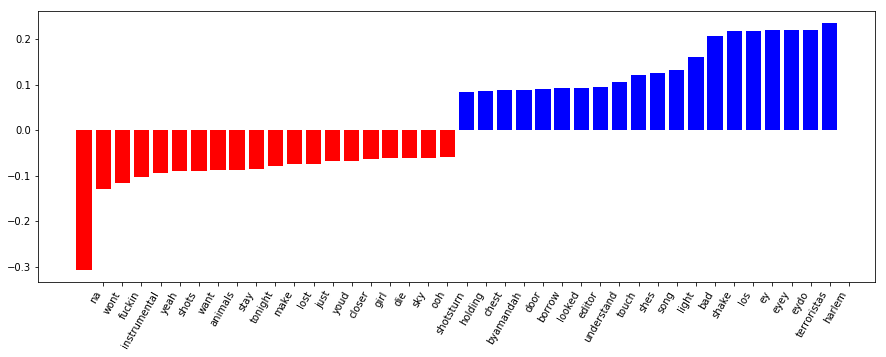

In [52]:
svm = LinearSVC()
svm.fit(X_train, rank_train)
plot_coefficients(svm, lyric_features)

In [1]:
import nltk
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
print(len(stopWords))
print(stopWords)

[nltk_data] Downloading package stopwords to /home/vcm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'stopwords' is not defined

In [9]:
from sklearn import cross_validation
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer

vectorizer2 = CountVectorizer(binary=True, stop_words=stopWords)
vectorizer2.fit(lyricsL)
lyric_features2 = vectorizer2.get_feature_names()
X2 = vectorizer2.transform(lyricsL)

In [10]:
print '{} instances'.format(X2.shape[0])
print '{} features'.format(X2.shape[1])

500 instances
10273 features
